# Исследование графа подписчиков

Этот блокнот воплощает идеи, описанные в [статьюшке](https://zen.yandex.ru/media/id/5acb3249168a91b1b5a409ff/o-nenormalnom-raspredelenii-kolichestva-druzei-5ad122e455876b6ea07cac12): построить граф дружбы между подписчиками [Матчасти](https://vk.com/mat.chast), и исследовать распределение его степеней. 

## Технические требования

1. Что нужно установить: библиотеку <a href = 'https://networkx.github.io/documentation/networkx-1.9/index.html'>networkx</a> для работы с графами (давно привычной вам командой pip)
2. Как получить доступ к API ВКонтакте: создать токен (схема есть <a href = 'http://all-for-vkontakte.ru/catalog/access-token-vkontakte'>например, здесь</a>).

Создайте себе токен и пропишите в переменную token ниже.

In [1]:
token = # здесь должен быть токен доступа к API VK, который вы получите

In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Список подписчиков

Скачиваем список подписчиков Матчасти, а для каждого из них потом загружаем список друзей. 

In [5]:
group_id = 'mat.chast'

In [10]:
import urllib.request
import json
users = json.loads(urllib.request.urlopen('https://api.vk.com/method/groups.getMembers?group_id='+group_id
                               +'&access_token='+token + "&v=5.74"
                              ).read().decode('utf-8'))
user_ids = users['response']['items']
print(len(user_ids))

739


In [22]:
import time
from tqdm import tqdm_notebook

In [26]:
nf = []
totalf = []
for u in tqdm_notebook(user_ids):
    _friends = json.loads(urllib.request.urlopen('https://api.vk.com/method/friends.get?user_id='+str(u)
                                             +'&fields=name&access_token='+token+"&v=5.74").read().decode('utf-8'))
    fl = _friends.get('response', {}).get('items', [])
    n = len(fl)
    print(n, end=' ')
    nf.append(n)
    totalf.append(fl)
    time.sleep(0.5) # ставим паузу, потому что VK ограничивает число запросов в секунду. 

HBox(children=(IntProgress(value=0, max=739), HTML(value='')))

2108 264 249 375 184 285 341 570 
157 58 294 86 314 887 99 212 640 49 399 291 844 157 647 323 332 1 147 95 96 920 448 712 1826 160 114 86 123 445 401 108 258 402 688 249 772 264 474 643 126 374 15 839 80 2421 101 201 108 318 225 297 407 1336 965 114 184 98 426 176 431 548 71 255 335 22 215 703 81 421 272 365 357 217 195 886 528 167 274 484 209 188 483 203 174 103 1282 209 162 136 17 175 168 206 279 234 234 251 55 467 250 173 727 170 190 156 274 601 440 90 262 590 398 306 781 537 577 407 277 166 269 170 1011 0 0 137 875 95 128 394 357 319 394 180 313 87 227 56 303 122 617 347 611 473 783 66 58 127 290 94 152 73 275 198 249 172 385 564 358 49 3 158 13 688 225 48 277 135 245 235 344 333 1043 121 161 268 299 375 154 622 191 275 342 356 76 233 100 586 816 168 301 406 404 173 93 93 3893 1352 61 422 805 138 102 788 186 0 536 729 412 130 929 284 848 744 43 369 489 941 391 213 580 253 189 132 599 165 122 741 409 2 55 196 326 196 95 75 108 128 11 282 36 343 391 178 47 149 337 208 215 521 206 163

Чтобы можно было быстро воспроизвести дальнейшие вычисления, сохраним результат парсинга на диск:

In [27]:
import pickle
with open('friends_graph.pkl', 'wb') as f:
    pickle.dump([user_ids, nf, totalf], f)

Считываем назад с диска

In [28]:
import pickle
with open('friends_graph.pkl', 'rb') as f:
    user_ids, nf, totalf = pickle.load(f)

## Распределение числа всех друзей (не только подписчиков) - логнормальное

In [31]:
nf_vec = pd.Series(nf)
nf_vec = nf_vec[nf_vec>0]
nf_vec.describe()

count     711.000000
mean      278.839662
std       334.306892
min         1.000000
25%       102.500000
50%       204.000000
75%       357.000000
max      4606.000000
dtype: float64

Рисуем кривую Лоренца - удобное графическое отображение неравномерности. 

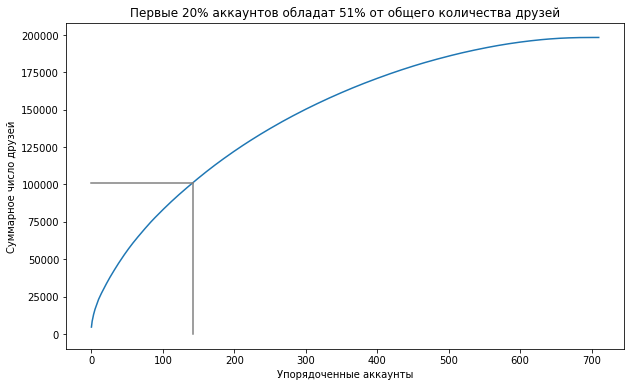

In [81]:
cumsum = nf_vec.sort_values(ascending=False).cumsum().reset_index(drop=True)
plt.figure(figsize=(10,6))
cumsum.plot()
p20 = int(len(cumsum)*0.2)
s20 = cumsum.iloc[p20]
plt.plot([p20, p20], [0, s20], c='gray');
plt.plot([0, p20], [s20, s20], c='gray');
plt.title('Первые {:.0%} аккаунтов обладат {:.0%} от общего количества друзей'.format(0.2, s20/sum(nf_vec)))
plt.xlabel('Упорядоченные аккаунты')
plt.ylabel('Суммарное число друзей');

In [83]:
print(s20 / nf_vec.sum())

0.5103427404100779


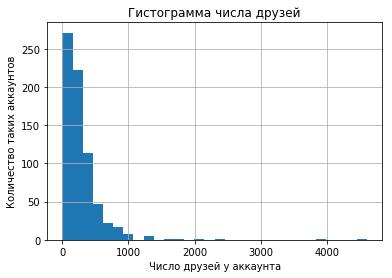

In [112]:
nf_vec.hist(bins=30);
plt.title('Гистограмма числа друзей')
plt.xlabel('Число друзей у аккаунта')
plt.ylabel('Количество таких аккаунтов');

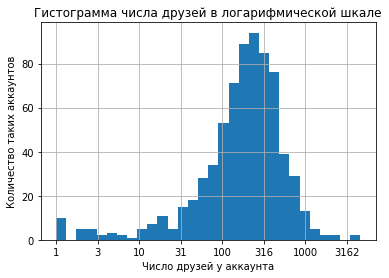

In [113]:
h = np.log10(nf_vec).hist(bins=30)
a = (10 ** h.get_xticks()).astype(int)
h.set_xticklabels(a)
plt.title('Гистограмма числа друзей в логарифмической шкале')
plt.xlabel('Число друзей у аккаунта')
plt.ylabel('Количество таких аккаунтов');

# Граф подписчиков

Теперь подключим библиотеку networkx, которая позволяет проводить расчёты на графах и визуализировать их.

In [117]:
import networkx as nx

Создадим граф, добавив туда всех подписчиков

In [123]:
G = nx.Graph()
G.add_nodes_from(user_ids)
G.add_edges_from([(uid1, friend['id']) 
                  for uid1, list_of_friends in zip(user_ids, totalf) 
                  for friend in list_of_friends if friend['id'] in user_ids])

Запомним имена тех из них, кто находится в друзьях хоть у кого-то ещё. 

In [137]:
names = {}
for uid1, list_of_friends in zip(user_ids, totalf):
    for friend in list_of_friends:
        if friend['id'] in user_ids:
            names[friend['id']] = friend['first_name'] + ' ' + friend['last_name']

Каков размер графа?

In [124]:
print(G.number_of_nodes(), G.number_of_edges())

739 1290


Воспользуемся готовым алгоритмом визуализации графа. Видим, что есть много точек, ни с кем не связанных.

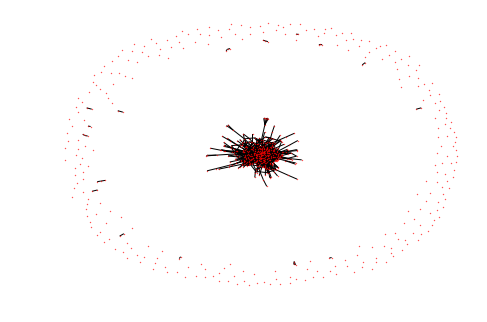

In [125]:
nx.draw(G, node_size  = 0.1)

Оказывается, библиотека networkx умеет отвечать на вопросы о свойствах графа, например, о том, является ли он связным.

In [126]:
nx.is_connected(G)

False

Посчитаем число соединённых компонент в графе.

In [127]:
subgraphs = [sg for sg in nx.connected_component_subgraphs(G)]
print(len(subgraphs))

295


In [128]:
comp_lengths = [len(sg.nodes()) for sg in subgraphs]
print(comp_lengths)

[3, 1, 424, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [129]:
G1 = subgraphs[np.argmax(comp_lengths)]

Тот алгоритм рисования графа, которым мы воспользовались, основан на воображаемых "пружинках" между узлами.

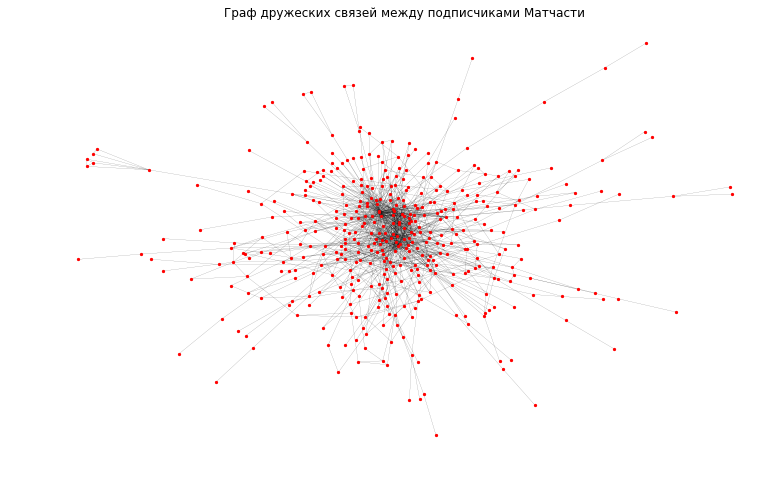

In [291]:
plt.figure(figsize = (10, 6))
nx.draw_spring(G1, node_size = 5, width=0.1)
plt.title('Граф дружеских связей между подписчиками Матчасти');

Есть и другие методы визуализации - например, с помощью концентрических окружностей.

In [393]:
labeldict = {uid:names.get(uid, '') if G1.degree(uid) > 25 else '' for uid in list(G1.nodes)}

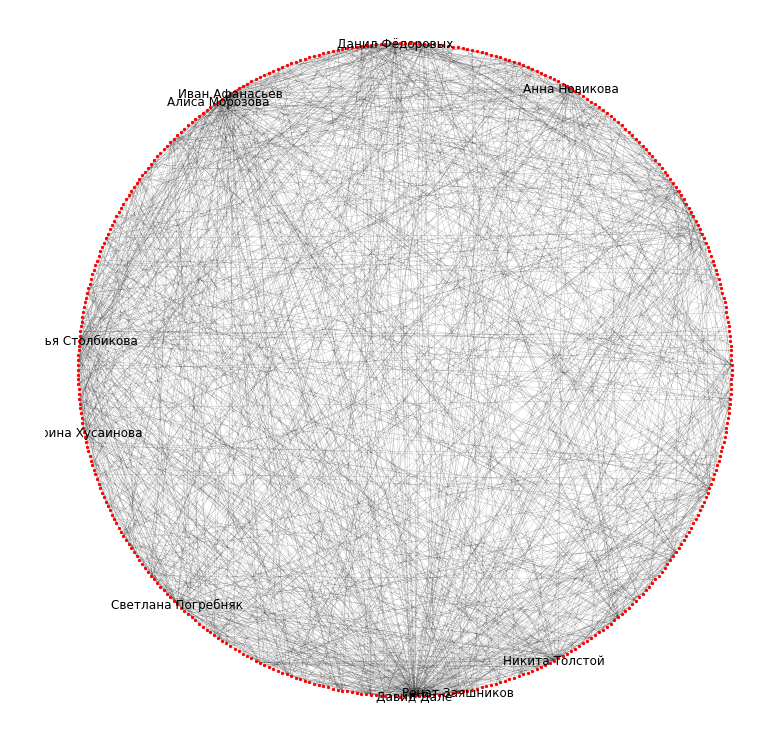

In [398]:
plt.figure(figsize = (10,10))
nx.draw_shell(G1, node_size = 5, width  = 0.1, labels=labeldict, with_labels = True)

# Распределение числа соседей в графе - Парето

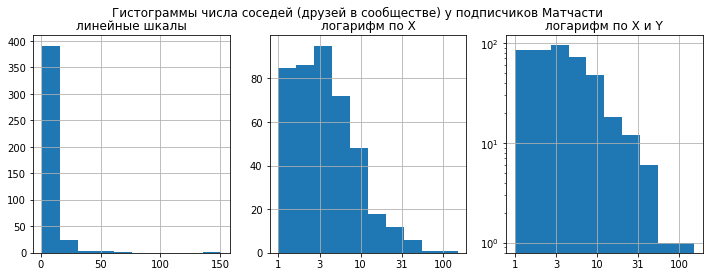

In [214]:
plt.figure(figsize=(12, 4))

deg = pd.Series(dict(G1.degree))
plt.subplot(1,3,1)
deg.hist()
plt.title("линейные шкалы")

plt.subplot(1,3,2)
h = np.log10(deg).hist()
a = (10 ** h.get_xticks()).astype(int)
h.set_xticklabels(a);
plt.title("логарифм по X")

plt.subplot(1,3,3)
h = np.log10(deg).hist()
a = (10 ** h.get_xticks()).astype(int)
h.set_xticklabels(a);
plt.yscale('log')
plt.title("логарифм по X и Y")

plt.suptitle('Гистограммы числа соседей (друзей в сообществе) у подписчиков Матчасти');

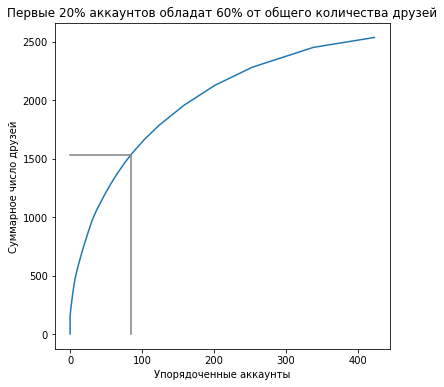

In [392]:
cumsum = deg.sort_values(ascending=False).cumsum().reset_index(drop=True)
plt.figure(figsize=(6,6))
pd.concat([pd.Series([0]), cumsum]).plot()
p20 = int(len(cumsum)*0.2)
s20 = cumsum.iloc[p20]
plt.plot([p20, p20], [0, s20], c='gray');
plt.plot([0, p20], [s20, s20], c='gray');
plt.title('Первые {:.0%} аккаунтов обладат {:.0%} от общего количества друзей'.format(0.2, s20/sum(deg)))
plt.xlabel('Упорядоченные аккаунты')
plt.ylabel('Суммарное число друзей');

Формула распределения Парето: $P(X>t)  = const \times t^{-k}$. Сейчас мы попробуем разными способами оценить параметр $k$. 

In [217]:
import scipy.stats

In [222]:
deg.describe()

count    424.000000
mean       5.981132
std       10.185728
min        1.000000
25%        2.000000
50%        3.000000
75%        6.000000
max      151.000000
dtype: float64

LinregressResult(slope=-0.9550551004494406, intercept=7.866869583893315, rvalue=-0.9139358371284285, pvalue=0.0014926020059151356, stderr=0.17314579847978717)

In [376]:
lr.slope

-0.9550551004494406

LinregressResult(slope=-0.9550551004494406, intercept=7.866869583893315, rvalue=-0.9139358371284285, pvalue=0.0014926020059151356, stderr=0.17314579847978717)


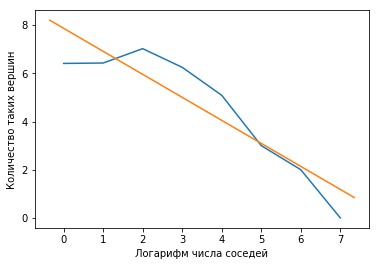

In [384]:
loglog = np.log2(np.log2(deg).round(0).value_counts()).sort_index()
lr = scipy.stats.linregress(loglog.index, loglog.values)
print(lr)
loglog.plot();
xx = np.array(plt.xlim())
plt.plot(xx, xx * lr.slope + lr.intercept);
plt.xlabel('Логарифм числа соседей')
plt.ylabel('Количество таких вершин');

In [228]:
params = scipy.stats.pareto.fit(deg, floc=0, fscale=1)
k = params[0]
print(k)

0.7976562499999997


/home/ddale/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


## Иллюстрируем нестабильность моментов распределения

In [273]:
moments = deg.mean(), deg.std()
print(moments)

(5.981132075471698, 10.185727865168563)


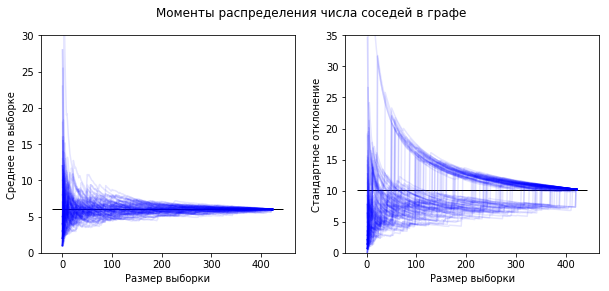

In [351]:
np.random.seed(40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(100):
    window = deg.sample(frac=1, random_state=i).expanding()
    window.mean().reset_index(drop=True).plot(c='blue', alpha=0.1, ax=ax1);
    window.std().reset_index(drop=True).plot(c='blue', alpha=0.1, ax=ax2);

ax1.hlines(moments[0], *plt.xlim(), lw=1)
ax2.hlines(moments[1], *plt.xlim(), lw=1)

ax1.set_xlabel('Размер выборки'); ax1.set_ylabel('Среднее по выборке')
ax2.set_xlabel('Размер выборки'); ax2.set_ylabel('Стандартное отклонение')
ax1.set_ylim(0, 30); ax2.set_ylim(0, 35)

plt.suptitle('Моменты распределения числа соседей в графе');

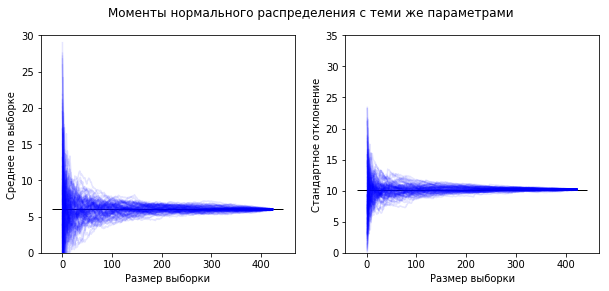

In [352]:
np.random.seed(40)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(100):
    sim = pd.Series(np.random.normal(size=len(deg)))
    sim = (sim - sim.mean()) / sim.std() * moments[1] + moments[0]
    window = sim.expanding()
    window.mean().reset_index(drop=True).plot(c='blue', alpha=0.1, ax=ax1);
    window.std().reset_index(drop=True).plot(c='blue', alpha=0.1, ax=ax2);

ax1.hlines(moments[0], *plt.xlim(), lw=1)
ax2.hlines(moments[1], *plt.xlim(), lw=1)

ax1.set_xlabel('Размер выборки'); ax1.set_ylabel('Среднее по выборке')
ax2.set_xlabel('Размер выборки'); ax2.set_ylabel('Стандартное отклонение')
ax1.set_ylim(0, 30); ax2.set_ylim(0, 35)

plt.suptitle('Моменты нормального распределения с теми же параметрами');

### Бонус: Центральность вершин

https://networkx.github.io/documentation/networkx-1.9/reference/algorithms.centrality.html

In [139]:
di = nx.degree_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:20]:
    print('{:30} has degree centrality {}'.format(names[uid], di[uid]))

Давид Дале                     has degree centrality 0.35697399527186763
Иван Афанасьев                 has degree centrality 0.15130023640661938
Дарья Столбикова               has degree centrality 0.1182033096926714
Алиса Морозова                 has degree centrality 0.11583924349881797
Анна Новикова                  has degree centrality 0.1111111111111111
Никита Толстой                 has degree centrality 0.09692671394799054
Данил Фёдоровых                has degree centrality 0.08983451536643025
Светлана Погребняк             has degree centrality 0.08274231678486997
Карина Хусаинова               has degree centrality 0.06619385342789598
Ренат Заяшников                has degree centrality 0.06619385342789598
Маргарита Ситалиева            has degree centrality 0.05673758865248227
Александр Краснов              has degree centrality 0.05437352245862884
Иван Смяткин                   has degree centrality 0.05437352245862884
Арман Нурлыбаев                has degree centrality 

In [140]:
di = nx.betweenness_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:20]:
    print('{:30} has betweenness centrality {}'.format(names[uid], di[uid]))

Давид Дале                     has betweenness centrality 0.5577997701689758
Иван Афанасьев                 has betweenness centrality 0.1254491858575796
Данил Фёдоровых                has betweenness centrality 0.0689762883435559
Александр Макаров              has betweenness centrality 0.050056869126594385
Александр Перевозчиков         has betweenness centrality 0.04610825153339689
Дарья Столбикова               has betweenness centrality 0.042317091979376754
Алиса Морозова                 has betweenness centrality 0.03341763973243587
Бимба Батожаргалов             has betweenness centrality 0.03321382587085117
Александр Панов                has betweenness centrality 0.03314987687748883
Tanya Grunina                  has betweenness centrality 0.032843828488656024
Наташа Вигуль                  has betweenness centrality 0.0316162691121109
Катерина Ксенофонтова          has betweenness centrality 0.02869421491630336
Ренат Заяшников                has betweenness centrality 0.02835

In [141]:
di = nx.closeness_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has closeness centrality {}'.format(names[uid], di[uid]))

Давид Дале                     has closeness centrality 0.5183823529411765
Иван Афанасьев                 has closeness centrality 0.4246987951807229
Алиса Морозова                 has closeness centrality 0.41348973607038125
Дарья Столбикова               has closeness centrality 0.40869565217391307
Анна Новикова                  has closeness centrality 0.3986804901036758
Вася Сиников                   has closeness centrality 0.39532710280373834
Никита Толстой                 has closeness centrality 0.39166666666666666
Ренат Заяшников                has closeness centrality 0.391304347826087
Данил Фёдоровых                has closeness centrality 0.39022140221402213
Светлана Погребняк             has closeness centrality 0.38878676470588236


In [142]:
di = nx.eigenvector_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has eigenvector centrality {}'.format(names[uid], di[uid]))

Давид Дале                     has eigenvector centrality 0.3865665169723544
Алиса Морозова                 has eigenvector centrality 0.24360054401133852
Иван Афанасьев                 has eigenvector centrality 0.24285679281612166
Дарья Столбикова               has eigenvector centrality 0.23050631768862365
Анна Новикова                  has eigenvector centrality 0.20722401784962935
Никита Толстой                 has eigenvector centrality 0.20388614912460348
Светлана Погребняк             has eigenvector centrality 0.17786451889240754
Карина Хусаинова               has eigenvector centrality 0.16293485867460936
Иван Смяткин                   has eigenvector centrality 0.15113294200063493
Катерина Александрова          has eigenvector centrality 0.14331996910464262
